The goal of this notebook is to perform some preliminary simulations with the Kaiser WMH population. These results will be used for an ISC meeting presentation.

In [1]:
import os
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from microsim.person_filter import PersonFilter
from microsim.trials.trial_description import KaiserTrialDescription
from microsim.trials.trial_type import TrialType
from microsim.trials.trial import Trial
from microsim.trials.trial_outcome_assessor_factory import TrialOutcomeAssessorFactory
from microsim.treatment import TreatmentStrategiesType, DefaultTreatmentsType
from microsim.treatment_strategy_repository import TreatmentStrategyRepository
from microsim.bp_treatment_strategies import SprintForSbpRiskThreshold
from microsim.statin_treatment_strategies import StatinTreatmentStrategy
from microsim.population_factory import PopulationFactory
from microsim.cv_model_repository import CVModelRepository
from microsim.outcome import OutcomeType
from microsim.modality import Modality

import sys
print(sys.version)

3.9.13 (main, Sep 27 2022, 07:05:21) 
[Clang 14.0.0 (clang-1400.0.29.102)]


In [2]:
pd.set_option('future.no_silent_downcasting', True) #make the calculation here future-proof

### Part 1: determine the overall risk in the kaiser CCM population, without specifically attending to CCM as a risk factor

  - initialize a kaiser population
  - use the intercept only risk model that does not include CCM covariates
  - run a 4 year trial with "intensive treatment” define as:  statin guidelines (use statin for all with risk > 7.5%) + risk-based SPRINT      guideline (implement SPRINT for all individuals over 7.5% who meet SPRINT bp criteria)
  - compare treatment in usual care vs. intensive treatment by baseline risk quintiles. (for each quintile define the range of risks, and       then look at bp meds added and statins added)
  - compare all outcomes — cognitive, dementia, cardiovascular, quality of life in treated vs. usual care.

In [3]:
%%time
pf = PersonFilter() 
#pf.add_filter("person", 
#              "lowCvLimit", 
#              lambda x: (CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10)<0.075))
pf.add_filter("df",
              "noStatin",
              lambda x: x[DefaultTreatmentsType.STATIN.value]==0)

cvRiskCutoff=0.075
wmhSpecific=False

ts = TreatmentStrategyRepository()
ts._repository[TreatmentStrategiesType.BP.value] = SprintForSbpRiskThreshold(cvRiskCutoff=cvRiskCutoff, wmhSpecific=wmhSpecific)
ts._repository[TreatmentStrategiesType.STATIN.value] = StatinTreatmentStrategy(cvRiskCutoff=cvRiskCutoff, wmhSpecific=wmhSpecific)

sampleSize = 300000
duration = 4
td = KaiserTrialDescription(trialType = TrialType.COMPLETELY_RANDOMIZED,
                            blockFactors=list(),
                            sampleSize = sampleSize, 
                            duration = duration, 
                            treatmentStrategies = ts,
                            nWorkers = 5, 
                            personFilters=pf,
                            wmhSpecific=False) 

tr = Trial(td)

tr.print_covariate_distributions()

                          Printing covariate information for people still alive...
                          self=treated, alive people count=  300000               other=control, alive people count=  300000  
                          self=treated, unique alive people count=  143368        other=control, unique alive people count=  143174  
                          self                                                    other
                          -----------------------------------------------------   -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd     min     0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------   -----------------------------------------------------
                    age    45.0    57.0    63.0    70.0   112.0    64.0     9.3    45.0    57.0    63.0    70.0   112.0    63.9     9.3
                    sbp  

In [4]:
%%time
tr.run()

toa = TrialOutcomeAssessorFactory.get_trial_outcome_assessor()
tr.analyze(toa)

tr

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Trial is completed.
CPU times: user 5min 7s, sys: 8min 16s, total: 13min 24s
Wall time: 24min 30s


Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 Person Filters:
	    filter type   filter name    
	             df   noStatin       

	Population type: PopulationType.KAISER
Trial
	Trial completed: True
Trial results:
	Analysis: linear
                            Z   Z SE pValue Inter.
               qalys:   0.024  0.002  0.000  3.699
             meanGCP:   0.119  0.019  0.000 52.746
             lastGCP:   0.135  0.025  0.000 51.152
	Analysis: logistic
                            Z   Z SE pValue Inter.
               death:  -0.098  0.010  0.000 -2.398
            anyEvent:  -0.045  0.006  0.000  0.801
    vascEventOrDeath:  -0.239  0.008  0.000 -1.837
           vascEvent:  -0.454  0.011  0.000 -2.538
            cogEvent:   0.006  0.005  0.239  0.507
	Analysis: cox
                            Z   Z SE pValue
            deathCox:  -0.094  0.009  0.000       
   

In [5]:
tr.print_treatment_strategy_variables_information()

                          Printing treatment strategy variable information at the end of the trial...
                          self=treated, alive people count=  277163  
                          self=treated & alive, unique people count=  138664  
                          self
                          -----------------------------------------------------
                          proportions
                          -----------
            bpMedsAdded
                      0   0.57
                      1   0.14
                      2   0.14
                      3   0.12
                      4   0.03
           statinsAdded
                      0   0.26
                      1   0.74
                          -----------------------------------------------------
                          proportions in each quintile
                          -----------------------------------------------------
                          bpMedsAdded
       CV risk quintile      0       1      

### Part 3: determine the overall risk in the kaiser CCM population, with attending to CCM as a risk factor

 - initialize a kaiser population
 - use the CCM risk model that does  include CCM covariates
 - run a 4 year trial with "intensive treatment” define as:  statin guidelines (use statin for all with risk > 7.5%) + risk-based SPRINT      guideline (implement SPRINT for all individuals over 7.5% who meet SPRINT bp criteria)
 - compare treatment in usual care vs. intensive treatment by baseline risk quintiles. (for each quintile define the range of risks, and      then look at bp meds added and statins added)
 - compare all outcomes — cognitive, dementia, cardiovascular, quality of life in intensive vs. usual care.

In [6]:
pf = PersonFilter() 
#pf.add_filter("person", 
#              "lowCvLimit", 
#              lambda x: (CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10)<0.075))
pf.add_filter("df",
              "noStatin",
              lambda x: x[DefaultTreatmentsType.STATIN.value]==0)

wmhSpecific=True
cvRiskCutoff=0.075

ts = TreatmentStrategyRepository()
ts._repository[TreatmentStrategiesType.BP.value] = SprintForSbpRiskThreshold(cvRiskCutoff=cvRiskCutoff, wmhSpecific=wmhSpecific)
ts._repository[TreatmentStrategiesType.STATIN.value] = StatinTreatmentStrategy(cvRiskCutoff=cvRiskCutoff, wmhSpecific=wmhSpecific)

sampleSize = 300000
duration = 4
td = KaiserTrialDescription(trialType = TrialType.COMPLETELY_RANDOMIZED,
                            blockFactors=list(),
                            sampleSize = sampleSize, 
                            duration = duration, 
                            treatmentStrategies = ts,
                            nWorkers = 5, 
                            personFilters=pf,
                            wmhSpecific=True) 

tr = Trial(td)

tr.print_covariate_distributions()

                          Printing covariate information for people still alive...
                          self=treated, alive people count=  300000               other=control, alive people count=  300000  
                          self=treated, unique alive people count=  143120        other=control, unique alive people count=  143412  
                          self                                                    other
                          -----------------------------------------------------   -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd     min     0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------   -----------------------------------------------------
                    age    45.0    57.0    63.0    70.0   113.0    63.9     9.3    45.0    57.0    63.0    70.0   113.0    64.0     9.3
                    sbp  

In [7]:
%%time
tr.run()

toa = TrialOutcomeAssessorFactory.get_trial_outcome_assessor()
tr.analyze(toa)

tr

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Trial is completed.
CPU times: user 7min 20s, sys: 27min 54s, total: 35min 15s
Wall time: 1h 3min 25s


Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 Person Filters:
	    filter type   filter name    
	             df   noStatin       

	Population type: PopulationType.KAISER
Trial
	Trial completed: True
Trial results:
	Analysis: linear
                            Z   Z SE pValue Inter.
               qalys:   0.024  0.002  0.000  3.700
             meanGCP:   0.121  0.019  0.000 52.749
             lastGCP:   0.138  0.025  0.000 51.157
	Analysis: logistic
                            Z   Z SE pValue Inter.
               death:  -0.105  0.010  0.000 -2.399
            anyEvent:  -0.035  0.006  0.000  0.801
    vascEventOrDeath:  -0.221  0.008  0.000 -1.848
           vascEvent:  -0.399  0.011  0.000 -2.566
            cogEvent:   0.009  0.005  0.098  0.511
	Analysis: cox
                            Z   Z SE pValue
            deathCox:  -0.101  0.009  0.000       
   

In [8]:
tr.print_treatment_strategy_variables_information()

                          Printing treatment strategy variable information at the end of the trial...
                          self=treated, alive people count=  277337  
                          self=treated & alive, unique people count=  138396  
                          self
                          -----------------------------------------------------
                          proportions
                          -----------
            bpMedsAdded
                      0   0.63
                      1   0.12
                      2   0.13
                      3   0.11
                      4   0.02
           statinsAdded
                      0   0.40
                      1   0.60
                          -----------------------------------------------------
                          proportions in each quintile
                          -----------------------------------------------------
                          bpMedsAdded
       CV risk quintile      0       1      

### Part 2: compare how treatment varies in the kaiser CCM population, depending on whether we use an intercept only model or a model that considers CCM risk

 - initialize a kaiser population. clone it.
 - compare the assigned risk quintile on both models
 - in one cloned population, use the intercept only risk model and run teh sim for one year with the intensive treatment arm.
 - in the other cloned population, use the CCM risk model and run teh sim for one year with the intensive treatment arm
 - match individual between teh two cloned populations. 
 - compare treatment between the two cloned populations (e.g. how many patients added/subtracted bp meds, statins)
 - compare treatment between teh cloned populations stratified by baseline risk (e.g. rows are risk quintiles from the intercept-only model, columns are risk quintiles form the CCM model), cell values are delta bp meds. repeat the same table but, cells are delta statins.

In [9]:
#pop1 is using wmh information
popSize = 100000
pop1 = PopulationFactory.get_kaiser_population(n=popSize)
pop2 = pop1.copy()
pop2._modelRepository

{'dynamicRiskFactors': <microsim.cohort_risk_model_repository.CohortDynamicRiskFactorModelRepository at 0x63af33e20>,
 'defaultTreatments': <microsim.cohort_risk_model_repository.CohortDefaultTreatmentModelRepository at 0x3741ac430>,
 'outcomes': <microsim.outcome_model_repository.OutcomeModelRepository at 0x3c09ef760>,
 'staticRiskFactors': <microsim.cohort_risk_model_repository.CohortDynamicRiskFactorModelRepository at 0x63af33e20>}

In [10]:
#by creation pop2 is similar to pop1 but we are now using a repository with wmhSpecific=False
pop2ModelRepository = PopulationFactory.get_kaiser_population_model_repo(wmhSpecific=False)
pop2._modelRepository = pop2ModelRepository._repository
pop2._modelRepository

{'dynamicRiskFactors': <microsim.cohort_risk_model_repository.CohortDynamicRiskFactorModelRepository at 0x3adf5feb0>,
 'defaultTreatments': <microsim.cohort_risk_model_repository.CohortDefaultTreatmentModelRepository at 0x32209f280>,
 'outcomes': <microsim.outcome_model_repository.OutcomeModelRepository at 0x322226f40>,
 'staticRiskFactors': <microsim.cohort_risk_model_repository.CohortStaticRiskFactorModelRepository at 0x322867100>}

In [11]:
#find the CV risks at baseline, before advacing at all, using the appropriate model
from microsim.cv_model_repository import CVModelRepository
import numpy as np
cvModelRepository = CVModelRepository(wmhSpecific=True)
popAlive = filter(lambda x: x.is_alive, pop1._people)
cvRiskList1 = list(map(lambda x: cvModelRepository.select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
cvRiskBoundaries1 = np.quantile(cvRiskList1, np.linspace(0, 1, 6))
cvRiskQuintiles1 = np.digitize(cvRiskList1, cvRiskBoundaries1, right=False)
cvRiskQuintiles1[cvRiskList1 == cvRiskBoundaries1[-1]] = 5

cvModelRepository = CVModelRepository(wmhSpecific=False)
popAlive = filter(lambda x: x.is_alive, pop2._people)
cvRiskList2 = list(map(lambda x: cvModelRepository.select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
cvRiskBoundaries2 = np.quantile(cvRiskList2, np.linspace(0, 1, 6))
cvRiskQuintiles2 = np.digitize(cvRiskList2, cvRiskBoundaries2, right=False)
cvRiskQuintiles2[cvRiskList2 == cvRiskBoundaries2[-1]] = 5

In [12]:
binEdges = np.arange(0.5, 6.5, 1)
proportionsInQuintiles = np.histogram2d(cvRiskQuintiles1,cvRiskQuintiles2, bins=[binEdges, binEdges])[0]/popSize

print(" "*25, "-"*53)
print(" "*25, "proportion of people in CV risk quintile bins")
print(" "*25, "-"*53)
risks = ["1", "2", "3", "4", "5"]
print(" "*25, "CV risk intercept-only")
print(" "*3 + "CV risk WMH-specific      " + "       ".join(risks))
for i,row in enumerate(np.flip(proportionsInQuintiles, axis=0)/proportionsInQuintiles.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 7.2f} " 
    print(printString) 

                          -----------------------------------------------------
                          proportion of people in CV risk quintile bins
                          -----------------------------------------------------
                          CV risk intercept-only
   CV risk WMH-specific      1       2       3       4       5
                      5    0.00    0.01    0.02    0.05    0.11 
                      4    0.00    0.02    0.03    0.06    0.09 
                      3    0.01    0.01    0.09    0.09    0.00 
                      2    0.01    0.13    0.06    0.00    0.00 
                      1    0.17    0.03    0.00    0.00    0.00 


In [13]:
#set up the appropriate treatment strategies for the two populations
ts1 = TreatmentStrategyRepository()
ts1._repository[TreatmentStrategiesType.BP.value] = SprintForSbpRiskThreshold(cvRiskCutoff=0.075, wmhSpecific=True)
ts1._repository[TreatmentStrategiesType.STATIN.value] = StatinTreatmentStrategy(cvRiskCutoff=0.075, wmhSpecific=True)

ts2 = TreatmentStrategyRepository()
ts2._repository[TreatmentStrategiesType.BP.value] = SprintForSbpRiskThreshold(cvRiskCutoff=0.075, wmhSpecific=False)
ts2._repository[TreatmentStrategiesType.STATIN.value] = StatinTreatmentStrategy(cvRiskCutoff=0.075, wmhSpecific=False)

In [14]:
#make the predictions
pop1.advance(years=1, treatmentStrategies=ts1, nWorkers=5)
pop2.advance(years=1, treatmentStrategies=ts2, nWorkers=5)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [15]:
#print the proportions for bpMedsAdded differences
ts = TreatmentStrategiesType.BP.value
tsv = "bpMedsAdded"
#popAlive = filter(lambda x: x.is_alive, pop1._people)
popAlive = pop1._people
bpMedsAddedList1 = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))

popAlive = pop2._people
bpMedsAddedList2 = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))

bpMedsAddedDiffList = list(map(lambda x: x[1]-x[0], zip(bpMedsAddedList1, bpMedsAddedList2)))

from collections import Counter
tsvList = bpMedsAddedDiffList
tsvValueCounts = Counter(tsvList)
for key in sorted(tsvValueCounts.keys()):
    print(f"{key:>23} {tsvValueCounts[key]/len(tsvList): 6.4f}")

                     -3  0.0005
                     -2  0.0014
                     -1  0.0019
                      0  0.9490
                      1  0.0216
                      2  0.0169
                      3  0.0087


In [16]:
#import matplotlib.pyplot as plt
#plt.hist(bpMedsAddedDiffList)
#plt.show()

In [17]:
#print the proportions for the statinsAdded differences
ts = TreatmentStrategiesType.STATIN.value
tsv = "statinsAdded"

popAlive = pop1._people
statinsAddedList1 = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))

popAlive = pop2._people
statinsAddedList2 = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))

saDiffList = list(map(lambda x: x[1]-x[0], zip(statinsAddedList1, statinsAddedList2)))

from collections import Counter
tsvList = saDiffList
tsvValueCounts = Counter(tsvList)
for key in sorted(tsvValueCounts.keys()):
    print(f"{key:>23} {tsvValueCounts[key]/len(tsvList): 6.4f}")

                     -1  0.0146
                      0  0.9016
                      1  0.0838


In [18]:
bmaDiffArray = np.zeros([5,5])
for i in range(1, 6):
    for j in range(1, 6):
        listForIAndJ = list(map(lambda y: y[2], filter(lambda x: (x[0]==i) & (x[1]==j), 
                                                       zip(cvRiskQuintiles2, cvRiskQuintiles1, bpMedsAddedDiffList))))
        if len(listForIAndJ)>0:
            bmaDiffArray[i-1, j-1] = np.mean(listForIAndJ)

In [19]:
#rows are based on risks from the intercept only models
#columns are based on risks from the wmh specific models
#cells are mean bpMedsAdded for all people in that cell
pd.DataFrame(bmaDiffArray)

,0,1,2,3,4
0,0.079513,-0.109623,-0.345837,0.0,-0.317585
1,0.627890,0.392683,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000


In [20]:
saDiffArray = np.zeros([5,5])
for i in range(1, 6):
    for j in range(1, 6):
        listForIAndJ = list(map(lambda y: y[2], filter(lambda x: (x[0]==i) & (x[1]==j), 
                                                       zip(cvRiskQuintiles2, cvRiskQuintiles1, saDiffList))))
        if len(listForIAndJ)>0:
            saDiffArray[i-1, j-1] = np.mean(listForIAndJ)

In [21]:
#rows are based on risks from the intercept only models
#columns are based on risks from the wmh specific models
#cells are mean statinsAdded for all people in that cell
pd.DataFrame(saDiffArray)

,0,1,2,3,4
0,0.051623,-0.194142,-0.606587,-0.615385,-0.695538
1,0.457867,0.394922,-0.035498,-0.068980,-0.100511
2,0.000000,0.152360,0.026336,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000


### Part 4: compare risk distributions

 - compare the risk on an unrecalibrated ascvd risk model vs. risk on the recalibrated model


In [22]:
popSize = 200000
pop = PopulationFactory.get_kaiser_population(n=popSize)

In [23]:
cvModelRepository = CVModelRepository(wmhSpecific=True)
cvWmhSpecificRiskList = list(map(lambda x: cvModelRepository.select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
                                 pop._people))

cvModelRepository = CVModelRepository(wmhSpecific=False)
cvWmhInterceptRiskList = list(map(lambda x: cvModelRepository.select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
                                  pop._people))

#the only way to get the CV risks without using any WMH information is to remove the modality and WMH outcome from the people
for p in pop._people:
    p._outcomes[OutcomeType.WMH] = list()
    p._modality = Modality.NO.value

#I need to set this wmhSpecific flag to something...with the outcomes removed and no modality this should give the risk I need
#I verified that it does...using wmhSpecific=False, I get exactly the same risks
cvModelRepository = CVModelRepository(wmhSpecific=True) 
cvWmhNoRiskList = list(map(lambda x: cvModelRepository.select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
                           pop._people))

binEdges = np.concatenate((np.arange(0., 0.175, 0.025),  np.arange(0.2, 0.6,0.3), np.arange(1,1.1,1))) 
risks = [ "0.0-0.025", "0.025-0.05" , "0.05-0.075", "0.075-0.1"  , "0.1-0.125", "0.125-0.15" , "0.15-0.2" , " 0.2-0.5" , "  0.5-1."]

The scatter plot does not provide much information due to the overlap but at least you can see the pattern: CV risk increases when you consider the brain scan presence (included as the static risk factor modality in the simulation).

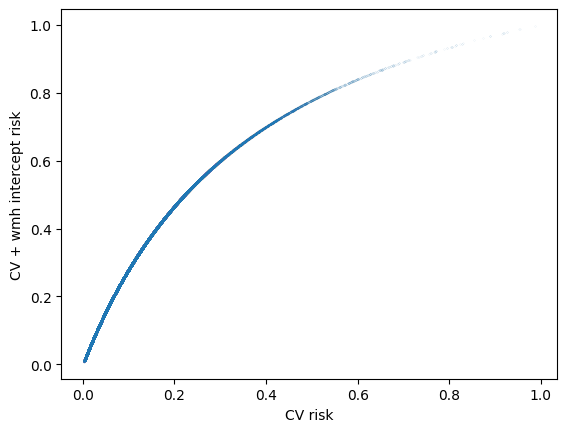

In [24]:
plt.scatter(cvWmhNoRiskList, cvWmhInterceptRiskList, s=0.001)
plt.xlabel("CV risk") #CV is essentially the CV risk without taking into account the brain scan at all
plt.ylabel("CV + wmh intercept risk")
plt.show()

With these bins you can see the changes in the risk of the population.

In [25]:
personCounts, xEdgesActual, yEdgesActual = np.histogram2d(cvWmhInterceptRiskList, cvWmhNoRiskList, bins=[binEdges,binEdges])
pc = personCounts
    
print(" "*25, "-"*53)
print(" "*25, "proportion of people in risk bins")
print(" "*25, "-"*53)
for i,row in enumerate(np.flip(pc, axis=0)/pc.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 10.2f} " 
    print(printString) 
print(" "*1, "CV+wmh intercept risk   " + "  ".join(risks))
print(" "*25, "CV risk")

                          -----------------------------------------------------
                          proportion of people in risk bins
                          -----------------------------------------------------
                 0.5-1.       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.08       0.00 
                0.2-0.5       0.00       0.00       0.05       0.11       0.08       0.06       0.08       0.02       0.00 
               0.15-0.2       0.00       0.01       0.11       0.00       0.00       0.00       0.00       0.00       0.00 
             0.125-0.15       0.00       0.07       0.00       0.00       0.00       0.00       0.00       0.00       0.00 
              0.1-0.125       0.00       0.07       0.00       0.00       0.00       0.00       0.00       0.00       0.00 
              0.075-0.1       0.02       0.05       0.00       0.00       0.00       0.00       0.00       0.00       0.00 
             0.05-0.075       0.08  

The risks separate in the lines below because there are a finite number of categories to assign the risk modification due to WMH. The lines are only on one side of the diagonal because the risk only increases when you consider the presence of WMH.

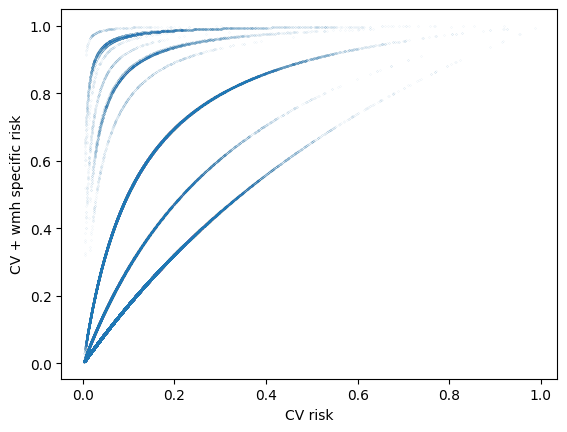

In [26]:
plt.scatter(cvWmhNoRiskList, cvWmhSpecificRiskList, s=0.001)
plt.xlabel("CV risk")
plt.ylabel("CV + wmh specific risk")
plt.show()

When you take into account all WMH-related information the risk changes seem to be more spread out.

In [27]:
personCounts, xEdgesActual, yEdgesActual = np.histogram2d(cvWmhSpecificRiskList, cvWmhNoRiskList, bins=[binEdges,binEdges])
pc = personCounts
    
print(" "*25, "-"*53)
print(" "*25, "proportion of people in risk bins")
print(" "*25, "-"*53)
for i,row in enumerate(np.flip(pc, axis=0)/pc.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 10.2f} " 
    print(printString) 
print(" "*2, "CV+wmh specific risk   " + "  ".join(risks))
print(" "*25, "CV risk")

                          -----------------------------------------------------
                          proportion of people in risk bins
                          -----------------------------------------------------
                 0.5-1.       0.00       0.01       0.01       0.01       0.02       0.02       0.03       0.06       0.00 
                0.2-0.5       0.00       0.03       0.03       0.03       0.03       0.04       0.05       0.04       0.00 
               0.15-0.2       0.01       0.00       0.01       0.04       0.04       0.00       0.00       0.00       0.00 
             0.125-0.15       0.00       0.01       0.02       0.03       0.00       0.00       0.00       0.00       0.00 
              0.1-0.125       0.00       0.01       0.06       0.00       0.00       0.00       0.00       0.00       0.00 
              0.075-0.1       0.00       0.05       0.03       0.00       0.00       0.00       0.00       0.00       0.00 
             0.05-0.075       0.01  

In contrast, when you compare risks by just adjusting the intercept versus using all WMH-related information some risks increase but some decrease.

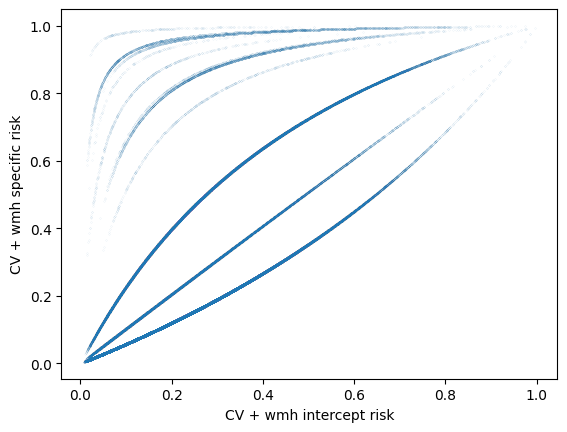

In [28]:
plt.scatter(cvWmhInterceptRiskList, cvWmhSpecificRiskList, s=0.001)
plt.ylabel("CV + wmh specific risk")
plt.xlabel("CV + wmh intercept risk")
plt.show()

In [29]:
personCounts, xEdgesActual, yEdgesActual = np.histogram2d(cvWmhSpecificRiskList, cvWmhInterceptRiskList, bins=[binEdges,binEdges])
pc = personCounts
    
print(" "*25, "-"*53)
print(" "*25, "proportion of people in risk bins")
print(" "*25, "-"*53)
for i,row in enumerate(np.flip(pc, axis=0)/pc.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 10.2f} " 
    print(printString) 
print(" "*2, "CV+wmh specific risk   " + "  ".join(risks))
print(" "*25, "CV+wmh intercept risk")

                          -----------------------------------------------------
                          proportion of people in risk bins
                          -----------------------------------------------------
                 0.5-1.       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.09       0.05 
                0.2-0.5       0.00       0.00       0.00       0.01       0.01       0.01       0.02       0.18       0.03 
               0.15-0.2       0.00       0.00       0.00       0.00       0.00       0.00       0.01       0.08       0.00 
             0.125-0.15       0.00       0.00       0.00       0.00       0.00       0.01       0.00       0.05       0.00 
              0.1-0.125       0.00       0.00       0.00       0.00       0.01       0.00       0.05       0.01       0.00 
              0.075-0.1       0.00       0.00       0.00       0.01       0.00       0.04       0.04       0.00       0.00 
             0.05-0.075       0.00  